# Univariate timeseries and exogenous effects

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist

# Import dataset

We import a dataset from Prophet's original repository. We then put it into sktime-friendly format, where the index is a `pd.PeriodIndex` and the colums are the time series.

In [ ]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")
display(y)

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572
...,...
2016-01-16,7.817223
2016-01-17,9.273878
2016-01-18,10.333775


: 

: 

# Fit model

Here, we fit the univariate Prophet. The `exogenous_effects` parameter let us specify different relations between exogenous variables and the time series. By default, all variables are assumed to be linearly related to the time series. 

In the example below, we set all variables starting with `cos` and `sin` to be part of the "seasonality" effect, which uses `prophetverse.effects.LinearEffect` to compute a multiplicative effect on the time series. 
The `cos` and `sin` variables are created by a `sktime.transformations.series.fourier.FourierFeatures` transformation, passed to `feature_transformer` parameter.

In [ ]:
from prophetverse.sktime import Prophetverse
from prophetverse.sktime.seasonality import seasonal_transformer
from prophetverse.effects.linear import LinearEffect
from prophetverse.utils.regex import starts_with


exogenous_effects = [LinearEffect(id="seasonality", prior=dist.Normal(0, 0.1), effect_mode="multiplicative", regex=starts_with(["sin", "cos"]))]

model = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    feature_transformer=seasonal_transformer(
        freq="D", yearly_seasonality=True, weekly_seasonality=True
    ),
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=20000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y)

100%|██████████| 20000/20000 [00:02<00:00, 9028.32it/s, init loss: 138546.8438, avg. loss [19001-20000]: -5114.6785]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[<prophetverse.effects.LinearEffect object at 0x16a553c90>],
             feature_transformer=FourierFeatures(fourier_terms_list=[10, 3],
                                                 freq='D',
                                                 keep_original_columns=True,
                                                 sp_list=['Y', 'W']),
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=20000)

: 

: 

## Forecasting

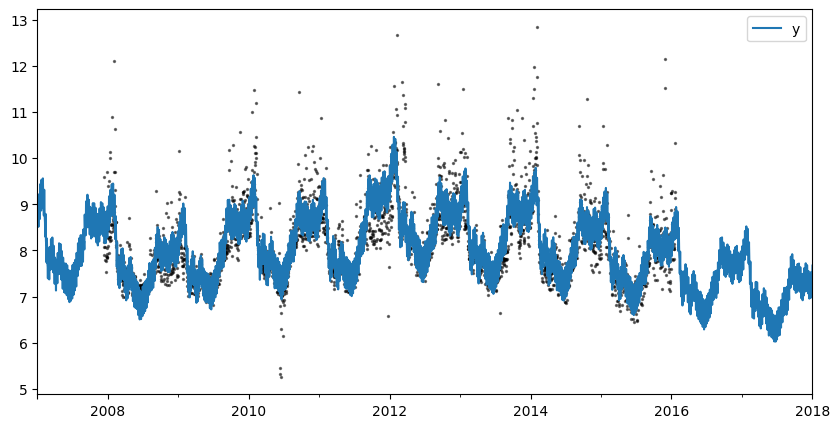

: 

: 

In [ ]:
forecast_horizon = pd.period_range("2007-01-01", "2018-01-01", freq="D")
fig, ax = plt.subplots(figsize=(10, 5))
preds = model.predict(fh=forecast_horizon)
preds.plot.line(ax=ax)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=0.5)

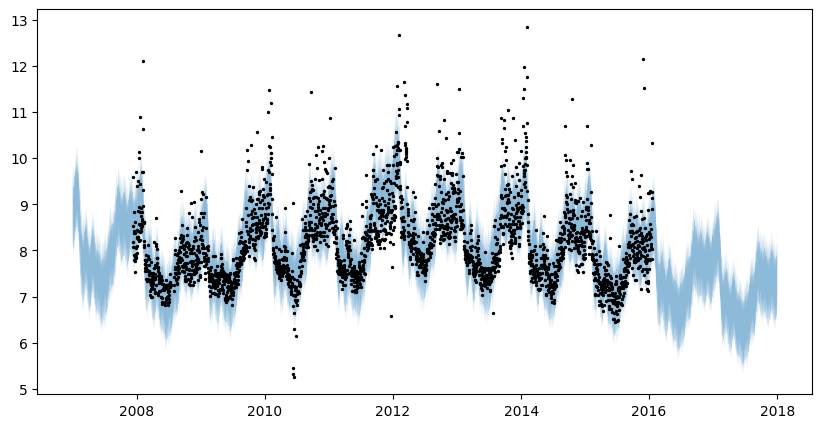

: 

: 

In [ ]:
quantiles = model.predict_quantiles(fh=forecast_horizon, alpha=[0.1, 0.9])
fig, ax = plt.subplots(figsize=(10, 5))
# Plot area between quantiles
ax.fill_between(quantiles.index.to_timestamp(), quantiles.iloc[:, 0], quantiles.iloc[:, -1], alpha=0.5)
ax.scatter(y.index, y, marker="o", color="k", s=2, alpha=1)

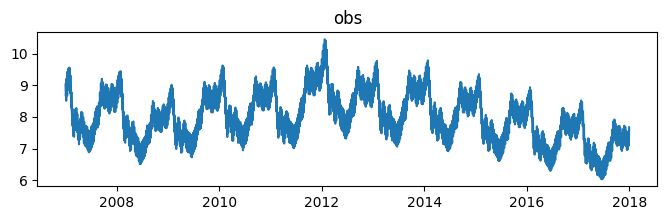

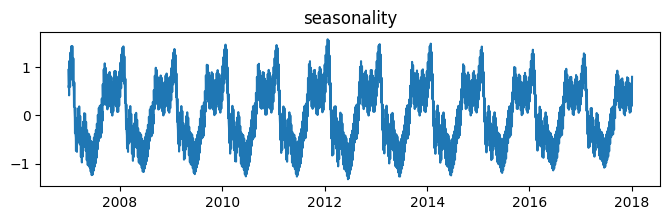

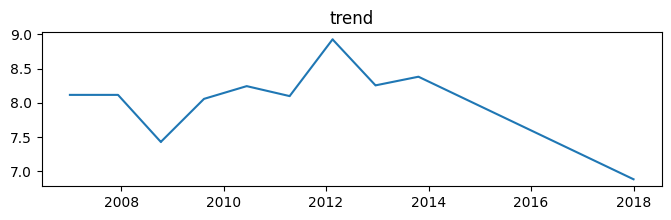

: 

: 

In [ ]:
sites = model.predict_all_sites(fh=forecast_horizon)
for column in sites.columns:
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(sites.index.to_timestamp(), sites[column], label=column)
    ax.set_title(column)
    fig.show()

## Non-linear effects

Let's create a synthetic exogenous variable with a logarithmic impact on the series. To estimate this variable's effect, we will pass a custom `prophetverse.effects.LogEffect` to the `exogenous_effects` parameter.

<Axes: xlabel='ds'>

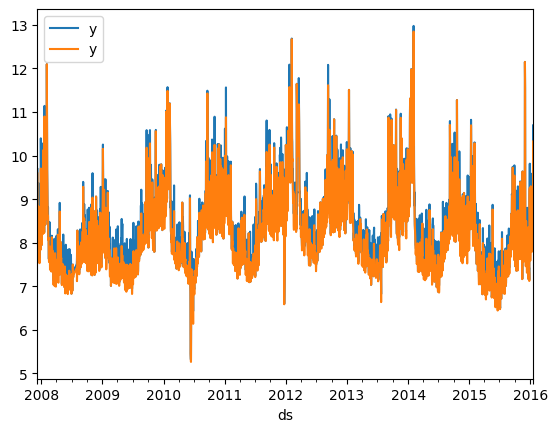

: 

: 

In [ ]:
y2 = y.copy()
# Set numpy seed
np.random.seed(0)

# Create random input
X = pd.DataFrame(
    np.abs(np.random.rand(len(y2), 1))**4,
    index=y2.index,
    columns=["exog"],
)
true_exog_effect = np.log(1.5 * X["exog"].values.reshape((-1, 1)) + 1) * 0.8
y2 = y + true_exog_effect
ax = y2.plot.line()
y.plot.line(ax=ax)

In [ ]:
from prophetverse.effects.log import LogEffect
import numpyro


exogenous_effects = [
    LinearEffect(
        prior=dist.Normal(0, 0.5),
        effect_mode="multiplicative",
        id="seasonality",
        regex=starts_with(["sin", "cos"]),
    ),
    LogEffect(
        rate_prior=dist.Gamma(2, 1),
        scale_prior=dist.Gamma(2, 1),
        effect_mode="additive",
        id="exog",
        regex=starts_with("exog"),
    ),
]

model = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    feature_transformer=seasonal_transformer(
        freq="D", yearly_seasonality=True, weekly_seasonality=True
    ),
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=50000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y2, X=X)

100%|██████████| 50000/50000 [00:06<00:00, 8011.32it/s, init loss: 992767.3750, avg. loss [47501-50000]: -5103.4305]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[<prophetverse.effects.LinearEffect object at 0x328e1f990>,
                                <prophetverse.effects.LogEffect object at 0x328c1bb50>],
             feature_transformer=FourierFeatures(fourier_terms_list=[10, 3],
                                                 freq='D',
                                                 keep_original_columns=True,
                                                 sp_list=['Y', 'W']),
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=50000)

: 

: 

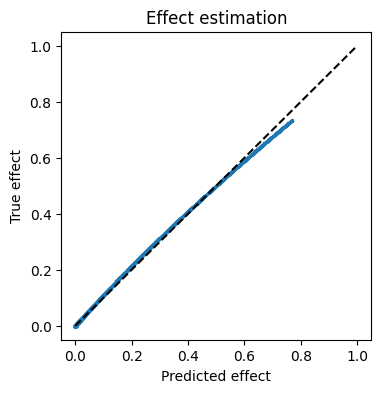

: 

: 

In [ ]:
sites = model.predict_all_sites(fh=X.index, X=X)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(sites["exog"],true_exog_effect, s=2)
# 45 degree line
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted effect")
ax.set_ylabel("True effect")
ax.set_title("Effect estimation")
fig.show()


In [ ]:
{k:v for k,v in model.inference_engine_.posterior_samples_.items() if k.startswith("exog__")}

{'exog__log_scale': Array(0.0956099, dtype=float32),
 'exog__log_rate': Array(0.85677356, dtype=float32)}

: 

: 

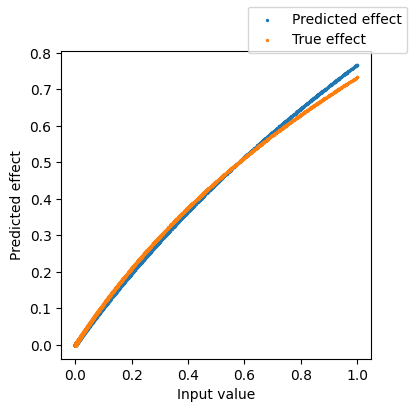

: 

: 

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X["exog"], sites["exog"], s=2, label="Predicted effect")
ax.scatter(X["exog"], true_exog_effect, s=2, label="True effect")
ax.set_xlabel("Input value")
ax.set_ylabel("Predicted effect")
fig.legend()
fig.show()

## Custom effect

In the last example, we used an effect that was imported from Prophetverse. You may, however, be interested in your own effects. Lets create a custom "Hill" effect, that is used in Marketing Mix Modelling applications.

In [ ]:
from prophetverse.effects.base import BaseEffect
import jax.numpy as jnp
class HillEffect(BaseEffect):
    """
    Represents a Hill effect in a time series model.

    Attributes:
        half_max_prior: Prior distribution for the half-maximum parameter.
        slope_prior: Prior distribution for the slope parameter.
        max_effect_prior: Prior distribution for the maximum effect parameter.
        effect_mode: Mode of the effect (either "additive" or "multiplicative").
    """

    def __init__(
        self,
        half_max_prior=None,
        slope_prior=None,
        max_effect_prior=None,
        effect_mode="multiplicative",
        **kwargs
    ):
        
        if half_max_prior is None:
            half_max_prior = dist.Gamma(2, 1)
        if slope_prior is None:
            slope_prior = dist.HalfNormal(2)
        if max_effect_prior is None:
            max_effect_prior = dist.Gamma(2, 1)
            
        self.half_max_prior = half_max_prior
        self.slope_prior = slope_prior
        self.max_effect_prior = max_effect_prior
        self.effect_mode = effect_mode
        super().__init__(**kwargs)

    def _apply(self, trend, data):
        """
        Computes the effect using the log transformation.

        Args:
            trend: The trend component.
            data: The input data.

        Returns:
            The computed effect.
        """

        half_max = self.sample("half_max", self.half_max_prior)
        slope = self.sample("slope", self.slope_prior)
        max_effect = self.sample("max_effect", self.max_effect_prior)

        effect = max_effect * (1 / (1 + (data/half_max)**-slope))
        effect = jnp.clip(effect, 0, max_effect)
        if self.effect_mode == "additive":
            return effect
        return trend * effect

: 

: 

In [ ]:
from prophetverse.effects.log import LogEffect


exogenous_effects = [
    LinearEffect(
        prior=dist.Normal(0, 0.1),
        effect_mode="multiplicative",
        id="seasonality",
        regex=starts_with(["sin", "cos"]),
    ),
    HillEffect(
        effect_mode="additive",
        id="exog",
        regex=starts_with("exog"),
    ),
]

model = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    feature_transformer=seasonal_transformer(
        freq="D", yearly_seasonality=True, weekly_seasonality=True
    ),
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=50000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y2, X=X)

100%|██████████| 50000/50000 [00:08<00:00, 5637.22it/s, init loss: 191288.2500, avg. loss [47501-50000]: -5146.1277]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[<prophetverse.effects.LinearEffect object at 0x328efdb10>,
                                <__main__.HillEffect object at 0x31d2b4e90>],
             feature_transformer=FourierFeatures(fourier_terms_list=[10, 3],
                                                 freq='D',
                                                 keep_original_columns=True,
                                                 sp_list=['Y', 'W']),
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=50000)

: 

: 

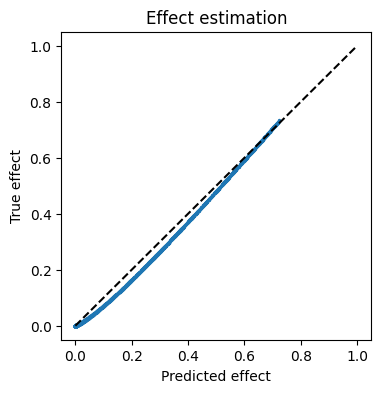

: 

: 

In [ ]:
sites = model.predict_all_sites(fh=X.index, X=X)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(sites["exog"], true_exog_effect, s=2)
# 45 degree line
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted effect")
ax.set_ylabel("True effect")
ax.set_title("Effect estimation")
fig.show()

In [ ]:
sites

,exog,obs,seasonality,trend
ds,,,,
2007-12-10,0.135092,9.016423,0.803421,8.085539
2007-12-11,0.299847,8.933081,0.554310,8.083349
2007-12-12,0.180328,8.609870,0.354533,8.081160
2007-12-13,0.132105,8.554662,0.334271,8.078979
2007-12-14,0.059507,8.474236,0.323269,8.076790
...,...,...,...,...
2016-01-16,0.000029,8.157171,0.614711,7.567007
2016-01-17,0.049795,8.583783,0.971020,7.566031
2016-01-18,0.397533,9.218627,1.270229,7.565058


: 

: 

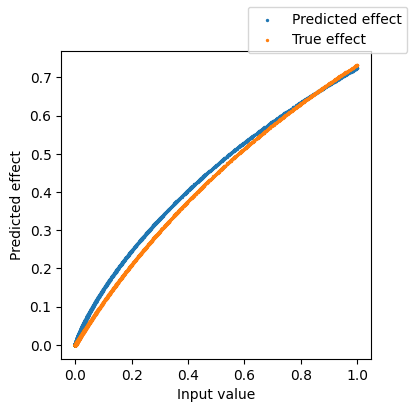

: 

: 

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X["exog"], sites["exog"], s=2, label="Predicted effect")
ax.scatter(X["exog"], true_exog_effect, s=2, label="True effect")
ax.set_xlabel("Input value")
ax.set_ylabel("Predicted effect")
fig.legend()
fig.show()